In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pickle
import time
import os
import tiktoken
import zipfile
import json
import gzip
import requests
import shutil

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
block_size = 64
batch_size = 90
max_iters = 100000
learning_rate = 2e-5
eval_iters = 100
n_head = 16
n_embd = 1024
n_layer = 16
dropout = 0.2

cpu


In [3]:
#this block downloads and cleans the datasets (each approx. 200MB)  a and saves them in datasets_folder
datasets_folder = "datasets"
num_datasets = 50

if not os.path.exists(datasets_folder):
    os.makedirs(datasets_folder)
for file_number in range(num_datasets):

    file_name = f"c4-{file_number:05d}.json.gz"
    unzipped_file_name = f"c4-{file_number:05d}-raw.json"
    cleaned_file_name = f"c4-{file_number:05d}.json"
    url = f"https://huggingface.co/datasets/allenai/c4/resolve/main/en/c4-train.{file_number:05d}-of-01024.json.gz?download=true"

    response = requests.get(url)

    zip_file_path = os.path.join(datasets_folder,file_name)
    unzipped_file_path = os.path.join(datasets_folder,unzipped_file_name)
    cleaned_file_path = os.path.join(datasets_folder,cleaned_file_name)
    with open(zip_file_path, 'wb') as file:
        file.write(response.content)

    allowed_characters = {chr(i) for i in range(32, 127)}
    allowed_characters.add('\n')
    def is_line_allowed(line):
        return all(c in allowed_characters for c in line)

    with gzip.open(zip_file_path, 'rb') as f_in:
        with open(unzipped_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    with open(unzipped_file_path, 'r', encoding="utf-8") as f, open(cleaned_file_path, 'w', encoding="utf-8") as file_out:
        for line in f:
            if is_line_allowed(line):
                file_out.write(line)

    os.remove(zip_file_path)
    os.remove(unzipped_file_path)

In [9]:
#this block reads all datasets and initializes the encoder and decoder
enc= tiktoken.encoding_for_model("gpt-4o")
tokens = []
def flatten(xss):
    return [x for xs in xss for x in xs]

data = []

for file_number in range(num_datasets):
    cleaned_file_name = f"c4-{file_number:05d}.json"
    cleaned_file_path = os.path.join(datasets_folder,cleaned_file_name)
    lines = []
    with open(cleaned_file_path, 'r', encoding="utf-8") as f:
        for line in f:
            encoded_text = enc.encode(json.loads(line)["text"])[:block_size + 1]
            if len(encoded_text) == block_size + 1:
                data.append(encoded_text)
                lines.append(encoded_text)




    tokens = sorted(set(flatten(lines) + tokens))

vocab_size = len(tokens)
token_to_int = {t: i for i,t in enumerate(tokens)}
int_to_token = {i: t for i,t in enumerate(tokens)}
encode = lambda s: [token_to_int[c] for c in enc.encode(s)]
decode = lambda l: enc.decode([int_to_token[i] for i in l])

data = [[token_to_int[t] for t in line] for line in data]

data = torch.tensor( data, dtype=torch.long)
print(decode(data[0].numpy()))
print(decode(encode("this tests if the encoder and decoder work")))
n = int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]

print(len(data))

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data), (batch_size,))
    x = torch.stack([data[i][:-1] for i in ix])
    y = torch.stack([data[i][1:] for i in ix])

    x,y = x.to(device), y.to(device)
    return x,y


77352
83873
Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone
the test from hello
264834


In [4]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(10):
            X,Y = get_batch(split)
            logits, loss = model(X,Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

datatype = torch.float32

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False, dtype=datatype)
        self.query = nn.Linear(n_embd, head_size, bias=False, dtype=datatype)
        self.value = nn.Linear(n_embd, head_size, bias=False, dtype=datatype)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd, dtype=datatype)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd, dtype=datatype),
            nn.ReLU(),
            nn.Linear(4*n_embd, n_embd, dtype=datatype),
            nn.Dropout(dropout),)

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd, dtype=datatype)
        self.ln2 = nn.LayerNorm(n_embd, dtype=datatype)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x+y)
        y = self.ffwd(x)
        x = self.ln2(x+y)
        return x


class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd, dtype=datatype)
        self.position_embedding_table = nn.Embedding(block_size, n_embd,dtype=datatype)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])

        self.ln_f = nn.LayerNorm(n_embd, dtype=datatype)
        self.lm_head = nn.Linear(n_embd, vocab_size, dtype=datatype)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape


        tok_emb = self.token_embedding_table(index)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if (targets is None):
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)

            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, index, max_new_tokens):
        for i in range(max_new_tokens):
            logits, loss = self.forward(index)

            logits = logits[:,-1,:]
            probs = F.softmax(logits, dim=-1)

            if i == 0:
                topk_results = 10
                results = torch.topk(probs, topk_results)
                print([(decode([results.indices.numpy()[0][result]]), f"{results.values.detach().numpy()[0][result]:.2%}")  for result in range(topk_results)])

            
            index_next = torch.multinomial(probs, num_samples=1)
            index = torch.cat((index, index_next), dim=1)
        return index


In [16]:
#this block creates a new model and starts training

model = GPTLanguageModel(vocab_size)

model.token_to_int = token_to_int
model.int_to_token = int_to_token
m = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):
    print(iter)
    if iter % eval_iters == 0:
        losses = estimate_loss()
        print(f"step: {iter}, train loss: {losses['train']:.5f}, val loss: {losses['val']:.5f}")

        path = 'model.pkl'
        with open(path,'wb') as f:
            pickle.dump(model,f)

    xb, yb = get_batch('train')

    logits, loss = model.forward(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

0
step: 0, train loss: 1.13398, val loss: 1.13401
1
2
3


KeyboardInterrupt: 

In [5]:
#this block reads a model from a given path and lets it generate text
model_path = 'D:/Informatik/LLM/model.pkl'
with open(model_path,'rb') as f:
    model = pickle.load(f)
    model.eval()
m = model.to(device)

enc= tiktoken.encoding_for_model("gpt-4o")
encode = lambda s: [model.token_to_int[c] for c in enc.encode(s)]
decode = lambda l: enc.decode([model.int_to_token[i] for i in l])


prompt = 'What is the difference'


context = torch.tensor(encode(prompt), dtype=torch.long, device=device)

generated_chars = decode(m.generate(context.unsqueeze(0), max_new_tokens=64-len(encode(prompt)))[0].tolist())

print(generated_chars)

[(' between', '97.99%'), (' of', '0.52%'), (' in', '0.34%'), (' to', '0.23%'), ('?', '0.14%'), ('?\n', '0.08%'), (' with', '0.07%'), (' for', '0.07%'), (' from', '0.06%'), (' that', '0.05%')]
What is the difference between applying for and receiving V-Ray drywall?
Unfortunately, fib311 replacement ceiling fan installation may affect my roofing fan, full length of installation, cracking processing and finding the right component for what is left untreated. Our team of architects at Opel Tl Meter would be happy to discuss your project next.
2015


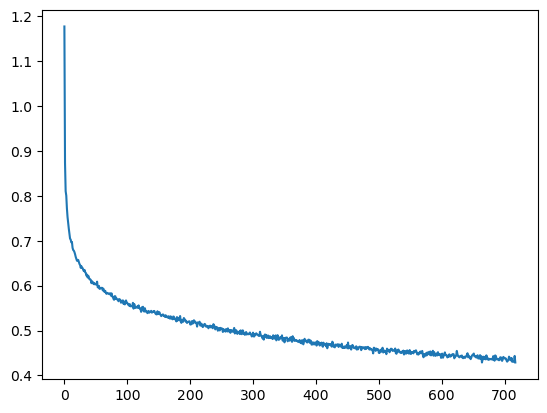

In [11]:
import matplotlib.pyplot as plt
train_losses = [loss.item() for loss in model.train_losses]
val_losses = [loss.item() for loss in model.val_losses]
plt.plot(train_losses)